<a href="https://colab.research.google.com/github/almutareb/llm-applications-with-ray/blob/main/ray_llm_search_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U langchain transformers datasets sentence-transformers faiss-cpu starlette typing-extensions==4.8.0 ray[serve]

## Building a doc index

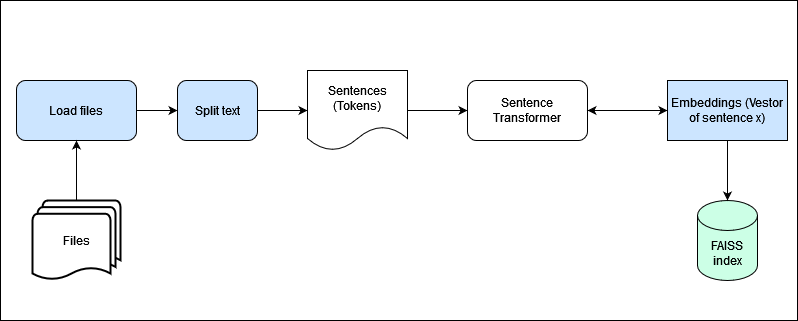

First we will build the index via the following steps.

  1. Download the content we want to index locally.

  2. Read the content and cut it into tiny little pieces (about a sentence each). This is because it is easier to match queries against pieces of a page rather than the whole page.

  3. Use the Sentence Transformers library from HuggingFace to generate a vector representation of each sentence.

  4. Embed those vectors in a Vector database (we use FAISS).

In [ ]:
# To download the files locally for processing, here's the command line
!wget -e robots=off --recursive --no-clobber --page-requisites --html-extension \
--convert-links --restrict-file-names=windows \
--domains docs.ray.io --no-parent https://docs.ray.io/en/master/

embeddings.py

In [ ]:
from typing import List

from langchain.embeddings.base import Embeddings
from sentence_transformers import SentenceTransformer


class LocalHuggingFaceEmbeddings(Embeddings):
  def __init__(self, model_id):
    # Should use the GPU by default
    self.model = SentenceTransformer(model_id)

  def embed_documents(self, texts:[str]) -> List[List[float]]:
    """Embed a list of documents using a locally running
    Hugging Face Sentence Transformer model
    Args:
      texts: The list of texts to embed.
    Returns:
      List of embeddings, one for each text.
    """
    embeddings = self.model.encode(texts)
    return embeddings

  def embed_query(self, text: str) -> List[float]:
    """embed a query using a locally running HF
    Sentence transformer.
    Args:
      text: The text to embed.
    Returns:
      Embeddings for the text
    """
    embedding = self.model.encode(text)
    return list(map(float, embedding))


build_vectore_store.py

In [ ]:
import time

from langchain.document_loaders import ReadTheDocsLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

#from embeddings import LocalHuggingFaceEmbeddings

FAISS_INDEX_PATH = "faiss_index"

loader = ReadTheDocsLoader("docs.ray.io/en/master/")

text_splitter = RecursiveCharacterTextSplitter(
    # set a small chunk size, just to show
    chunk_size=300,
    chunk_overlap=20,
    length_function=len,
)

# Stage one: read all the docs, split them into chunks.
st = time.time()
print("Loading documents ...")
docs = loader.load()
chunks = text_splitter.create_documents(
    [doc.page_content for doc in docs], metadatas=[doc.metadata for doc in docs]
)
et = time.time() -st
print(f"Time taken: {et} seconds.")

# Stage two: embed the docs
embeddings = LocalHuggingFaceEmbeddings("multi-qa-mpnet-base-dot-v1")
print(f"Loading chunks into vector store ...")
st = time.time()
db = FAISS.from_documents(chunks, embeddings)
db.save_local(FAISS_INDEX_PATH)
et = time.time() - st
print(f"Time taken: {et} seconds.")

In [ ]:
pip install starlette ray[serve]

serve_vectore_store.py

In [1]:
import time
from typing import List

from langchain.vectorstores import FAISS
from starlette.requests import Request
#from ray import serve

#from embeddings import LocalHuggingFaceEmbeddings

FAISS_INDEX_PATH = "faiss_index"

#@serve.deployment
class VectorSearchDeployment:
  def __init__(self):
    # Load the data from faiss
    st = time.time()
    self.embeddings = LocalHuggingFaceEmbeddings("multi-qa-mpnet-base-dot-v1")
    self.db = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings)
    et = time.time() - st
    print(f"Loading database took {et} seconds.")

  def search(self, query):
    results = self.db.max_marginal_relevance_search(query)
    retval = ""
    for i in range(len(results)):
      chunk = results[i]
      source = chunk.metadata["source"]
      retval = retval + f"From http://{source}\n\n"
      retval = retval + chunk.page_count
      retval = retval + "\n====\n\n"

    return retval

  async def __call__(self, request: Request) -> List[str]:
    return self.search(request.query_params["query"])

#deployment = VectorSearchDeployment.bind()

ModuleNotFoundError: ignored